# 1. 데이터 읽기

기상자료개방포털의 **동네예보 > 초단기실황** 데이터를 크롤러를 만들어 2019.08~2021.08 데이터를 수집하였다. 지역의 범위는 이어도를 제외한 전체지역이다.

In [1]:
import os
import glob 
import pandas as pd
import numpy as np
import gc

## 1.1 데이터 불러오기

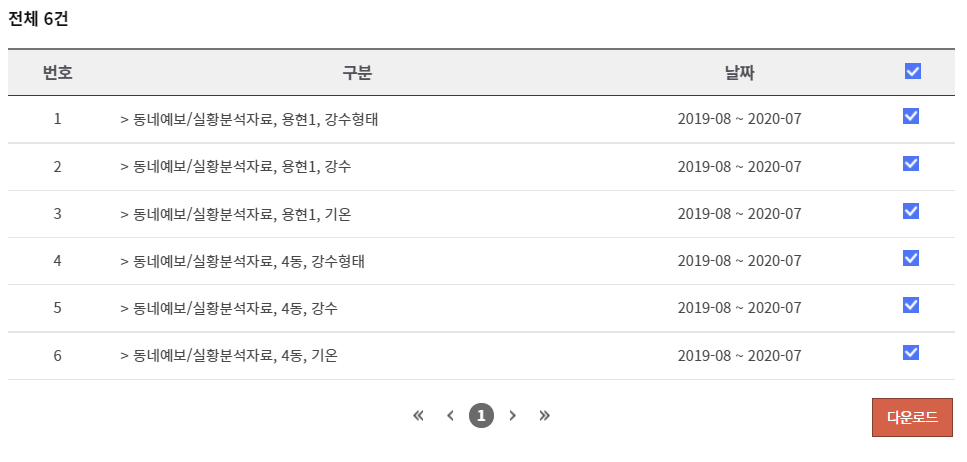

원래의 계획은 이렇게 다운받은 데이터를 구글 클라우드에 올리고, 코랩에서 압축두번 풀고 바로 작업하는 것이었다. 그러나 기상자료개방포털에서 위와같이 파일이름이 ,로 구분됨에 따라(다운로드 하면 _로 바뀐다) 숭의 1,3동/도화2,3동/용현1,4동 과 같이 ,로 구분된 지역이 파일이 나뉘어 게재되고, 다운로드 되었다. 실제 데이터는 4동과 같이 뒷부분 이름에만 들어있다. 코랩에서는 이것을 파악하기 어려워서 윈도우에서 압축을 풀고 파일명을 바꾸거나 몇개의 파일을 삭제한 뒤 csv파일만 남긴 후 압축하여 구글 드라이브로 다시 업로드 하였다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#우분투에서 다운받아 파일이름의 한글이 깨지므로 압축을 해제할 때 인코딩을 지정해주자.
!unzip -O cp949 '/content/drive/MyDrive/weathers/weathers.zip' -d '/content/'

In [4]:
file_list = glob.glob('/content/weathers/*.csv')
print(file_list[0])
len(file_list)

/content/weathers/성정2동_강수형태_202108_202108.csv


31596

In [5]:
rain_list=[]
temp_list=[]
rainSnow_list=[]


for fname in file_list:
  # print(fname)
  if len(fname.split("_"))>4: #대정읍_마라도포함_강수_201908_202007 (9개존재)
    if fname.split("_")[2].endswith('강수형태'):
      rainSnow_list.append(fname)
    if fname.split("_")[2].endswith('기온'):
      temp_list.append(fname)
    if fname.split("_")[2].endswith('강수'):
      rain_list.append(fname)
  else:
    if fname.split("_")[1].endswith('강수형태'):
      rainSnow_list.append(fname)
    if fname.split("_")[1].endswith('기온'):
      temp_list.append(fname)
    if fname.split("_")[1].endswith('강수'):
      rain_list.append(fname)
  
del file_list

총 31590개의 데이터가 필요한데 내가 다운받으면서 6개가 중복으로 들어간것 같다. </br>
31590/3 = 10530 개씩 강수, 강수형태, 기온 데이터가 존재해야하는데 부족하지 않으므로 나중에 duplicate로 살펴보는 것으로 하자.

In [6]:
print("rain_list",len(rain_list))
print("temp_list",len(temp_list))
print("rainSnow_list",len(rainSnow_list))
temp_list[-20:]

rain_list 10532
temp_list 10533
rainSnow_list 10531


['/content/weathers/일신동_기온_201908_202007.csv',
 '/content/weathers/강진면_기온_202108_202108.csv',
 '/content/weathers/삼각산동_기온_202108_202108.csv',
 '/content/weathers/안심4동_기온_201908_202007.csv',
 '/content/weathers/심천면_기온_201908_202007.csv',
 '/content/weathers/의흥면_기온_202108_202108.csv',
 '/content/weathers/박달2동_기온_202008_202107.csv',
 '/content/weathers/삼기면_기온_201908_202007.csv',
 '/content/weathers/망우제3동_기온_202008_202107.csv',
 '/content/weathers/신창면_기온_201908_202007.csv',
 '/content/weathers/풍호동_기온_202108_202108.csv',
 '/content/weathers/내이동_기온_202008_202107.csv',
 '/content/weathers/봉강면_기온_202008_202107.csv',
 '/content/weathers/증산동_기온_202108_202108.csv',
 '/content/weathers/금곡동_기온_202008_202107 (3).csv',
 '/content/weathers/온양읍_기온_202008_202107.csv',
 '/content/weathers/음성읍_기온_202108_202108.csv',
 '/content/weathers/안암동_기온_202108_202108.csv',
 '/content/weathers/정자2동_기온_202108_202108.csv',
 '/content/weathers/내남면_기온_202008_202107.csv']

In [7]:
RAIN = np.array(rain_list)
TEMP = np.array(temp_list)
RAINSNOW = np.array(rainSnow_list)
rain_split = np.array_split(RAIN,2)
temp_split = np.array_split(TEMP,2)
rainSnow_split = np.array_split(RAINSNOW,2)

rain1 = rain_split[0]
rain2 = rain_split[1]
temp1 = temp_split[0]
temp2 = temp_split[1]
rainSnow1 = rainSnow_split[0]
rainSnow2 = rainSnow_split[1]

In [8]:
print(len(rain1),len(rain2),len(temp1), len(temp2), len(rainSnow1),len(rainSnow2))

5266 5266 5267 5266 5266 5265


In [ ]:
for item in rain_list:
  if item.split("_")[0].endswith('용현1,4동'):
    print(item)

/content/weathers/용현1,4동_강수_202108_202108.csv
/content/weathers/용현1,4동_강수_202008_202107.csv
/content/weathers/용현1,4동_강수_201908_202007.csv


## 1.2 데이터 파악하기

* 첫번째 열 이름은 ' format: day'이고 마지막 열 이름은 'value location:81_91 Start : 20190801 '이다. **공백 주의**.
* value_location의 값은 **격자 X_격자 Y**값이다.
* 첫 시작일은 'value location:81_91 Start : 20190801 '에서 얻을 수 있고, day가 마지막 날이 되면 ' format: day'에 'Start : 20190901' 형태로 다음달 첫날 등장한다.

In [ ]:
sample = pd.read_csv('/content/weathers/가천면_강수_201908_202007.csv')
sample

,format: day,hour,value location:81_91 Start : 20190801
0,1,0.0,0.0
1,1,100.0,0.0
2,1,200.0,0.0
3,1,300.0,0.0
4,1,400.0,0.0
...,...,...,...
8790,31,1900.0,0.0
8791,31,2000.0,0.0
8792,31,2100.0,0.0
8793,31,2200.0,0.0


In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 3 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0    format: day                            8795 non-null   object 
 1   hour                                    8784 non-null   float64
 2   value location:81_91 Start : 20190801   8784 non-null   float64
dtypes: float64(2), object(1)
memory usage: 206.3+ KB


In [ ]:
sample.columns

Index([' format: day', 'hour', 'value location:81_91 Start : 20190801 '], dtype='object')

In [ ]:
sample[740:750]

,format: day,hour,value location:81_91 Start : 20190801
740,31,2000.0,0.0
741,31,2100.0,0.0
742,31,2200.0,0.0
743,31,2300.0,0.0
744,Start : 20190901,NaN,NaN
745,1,0.0,0.0
746,1,100.0,0.0
747,1,200.0,0.0
748,1,300.0,0.0
749,1,400.0,0.0


> 마지막에는 **outer join으로 합치기!**
http://www.gisdeveloper.co.kr/?p=8255

# 2. 대용량 데이터프레임 다루기

csv파일은 아래와 같이 날짜에는 1~ 마지막날까지 써있고 각 일자별로 0~23시까지 시간대별로 데이터가 존재한다. 한달단위로 데이터가 쓰여진 뒤에는 `Start : 20201001`처럼 날짜 열에 다음달의 시작일자가 등장한다. </br>
이것을 이제 배달데이터 처럼 **날짜를 년과 달을 붙여서 나타내고**, 이 데이터에는 지역이 적혀있지 않으니 새롭게 **읍면동, 격자X, 격자 Y라는 열을 만들어** 데이터를 넣어줄 것이다. 문제는 데이터가 너무나 많아서 3가지 방법 중 **어떤 방법으로 시도해도 램이 감당하지 못하고 터져버리는 것**이다. 어떻게 해결하면 좋을까?

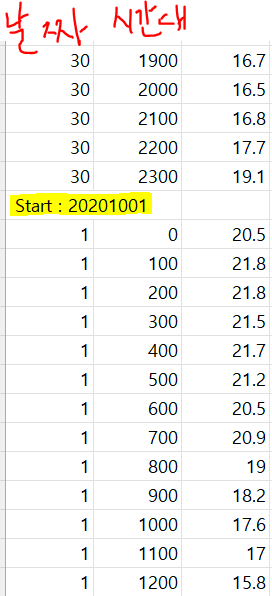

In [ ]:
location = pd.read_excel('/content/drive/MyDrive/동네예보 지점 좌표(위도 경도)_(20211001 기준).xlsx', engine='openpyxl')
location

,구분,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100),위치업데이트,Unnamed: 16
0,kor,1100000000,서울특별시,NaN,NaN,60,127,126,58,48.03,37,33,48.85,126.980008,37.563569,NaN,NaN
1,kor,1111000000,서울특별시,종로구,NaN,60,127,126,58,53.91,37,34,13.36,126.981642,37.570378,NaN,NaN
2,kor,1111051500,서울특별시,종로구,청운효자동,60,127,126,58,14.35,37,35,2.89,126.970652,37.584137,NaN,NaN
3,kor,1111053000,서울특별시,종로구,사직동,60,127,126,58,15.44,37,34,23.77,126.970956,37.573269,NaN,NaN
4,kor,1111054000,서울특별시,종로구,삼청동,60,127,126,59,2.32,37,34,56.73,126.983978,37.582425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,kor,5013060000,제주특별자치도,서귀포시,대천동,52,32,126,28,46.47,33,14,50.91,126.479575,33.247475,NaN,NaN
3775,kor,5013061000,제주특별자치도,서귀포시,중문동,51,32,126,26,12.40,33,14,53.44,126.436778,33.248178,NaN,NaN
3776,kor,5013062000,제주특별자치도,서귀포시,예래동,50,32,126,23,59.67,33,15,3.69,126.399908,33.251025,NaN,NaN
3777,kor,5019000000,이어도,NaN,NaN,28,8,0,0,0.00,0,0,0.00,0.000000,0.000000,NaN,NaN


In [ ]:
location.columns

Index(['구분', '행정구역코드', '1단계', '2단계', '3단계', '격자 X', '격자 Y', '경도(시)', '경도(분)',
       '경도(초)', '위도(시)', '위도(분)', '위도(초)', '경도(초/100)', '위도(초/100)', '위치업데이트',
       'Unnamed: 16'],
      dtype='object')

In [ ]:
location = location[['1단계', '2단계', '3단계', '격자 X', '격자 Y']]
location

,1단계,2단계,3단계,격자 X,격자 Y
0,서울특별시,NaN,NaN,60,127
1,서울특별시,종로구,NaN,60,127
2,서울특별시,종로구,청운효자동,60,127
3,서울특별시,종로구,사직동,60,127
4,서울특별시,종로구,삼청동,60,127
...,...,...,...,...,...
3774,제주특별자치도,서귀포시,대천동,52,32
3775,제주특별자치도,서귀포시,중문동,51,32
3776,제주특별자치도,서귀포시,예래동,50,32
3777,이어도,NaN,NaN,28,8


## 방법1. 루프를 돌때마다 concat으로 합쳐주기

### **절대! 금지!** 하루종일해도 결과를 얻을 수 없다.

In [ ]:
rain_df = pd.DataFrame(columns=['날짜', '시간대', '읍면동', '강수형태','격자 X','격자 Y'])

In [ ]:
rain_df

,날짜,시간대,읍면동,강수,격자 X,격자 Y


데이터프레임을 일일히 읽어서 합치는것은 매우 오래 걸리므로 다른 곳으로 이동하고 싶다면 중간에 코랩의 런타임을 유지시키기 위해 F12를 눌러 콘솔에
아래의 코드를 붙여넣고 엔터를 누르자. 30분에 한번씩 코랩의 툴바가 클릭될 것이다.

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button").click() 
}setInterval(ClickConnect, 1800000)
```




In [ ]:
for fname in rain_list:
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼 추가 후 값 넣기'''
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  df.columns = ['날짜','시간대','강수']
  df.loc[:,'읍면동'] = level3 
  df.loc[:,'격자 X'] = xy[0]
  df.loc[:,'격자 Y'] = xy[1]
  
  '''날짜 col 재정의'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    df.loc[i,'날짜'] = start_date + df.loc[i,'날짜'] #이부분이 시간이 가장 오래걸림!
  
  '''재정렬 및 합치기'''
  df = df[['날짜', '시간대', '읍면동', '강수','격자 X','격자 Y']]
  rain_df = pd.concat([rain_df, df], ignore_index=True)

'''날짜 col 정제'''
rain_df = rain_df.drop(rain_df[rain_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
rain_df['날짜'] = pd.to_datetime(rain_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대바꾸기'''
rain_df= rain_df.astype({'시간대': 'int'}) 
rain_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in rain_df['시간대']]

rain_df  

In [ ]:
rain_df.to_csv('/content/drive/MyDrive/강수_2019_2021.csv',index=False, encoding="utf-8-sig")
rain_df.to_excel('/content/drive/MyDrive/강수_2019_2021.xlsx',index=False, encoding="utf-8-sig")

> 메모리 덜 쓰고 Pandas DataFrame 병합을 빠르게 하는 방법(여러 개의 용량 큰 파일) : https://emilkwak.github.io/pandas-dataframe-concat-efficiently

나는 그런데 그대로 병합하면 안되고, 각 프레임별로 읍면동, 격자X, 격자 Y데이터를 함께 붙여야 한다.

## 방법 2. 모든 데이터를 리스트에 각각 담아서 열로 붙이기

완료되기까지 **50분**이 걸리지 않지만...저장하고있는 리스트가 너무 많아서 코랩의 일반유저는 **램**이 한정되어 있어서 **램이 꽉차서** 세션이 다운되고 **런타임이 초기화**된다...

In [ ]:
temp_df = pd.DataFrame(columns=['날짜', '시간대','읍면동', '기온','격자X','격자Y'])
temp_df

,날짜,시간대,읍면동,기온,격자X,격자Y


In [ ]:
date=[]
level3_list=[]
x=[]
y=[]
hour=[]
temp=[]

for j,fname in enumerate(temp_list):
  print(j)
  df = pd.read_csv(fname)

  '''필요한 날짜, 격자X, 격자 Y, 읍면동 정보 얻기'''
  start_date = df.columns[-1].strip()[-8:-2]
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼명 재정의'''
  df.columns = ['날짜','시간대','기온']
  
  '''Start검색을 위해 날짜 컬럼 string 타입으로 변경'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    date.append(start_date + df.loc[i,'날짜'])
    level3_list.append(level3)
    x.append(xy[0])
    y.append(xy[1])
    hour.append(df.loc[i,'시간대'])
    temp.append(df.loc[i,'기온'])

In [ ]:
'''데이터 프레임의 열로 합치기'''
temp_df['날짜'] = date
temp_df['시간대'] = hour
temp_df['읍면동'] = level3_list
temp_df['기온'] = temp
temp_df['격자X'] = x
temp_df['격자Y'] = y

'''날짜 col 정제'''
# temp_df = temp_df.drop(temp_df[temp_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
temp_df['날짜'] = pd.to_datetime(temp_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대 배달데이터 형태로 바꾸기'''
temp_df= temp_df.astype({'시간대': 'int'}) 
temp_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in temp_df['시간대']]

temp_df 

In [ ]:
temp_df.to_csv('/content/drive/MyDrive/온도_2019_2021.csv',index=False, encoding="utf-8-sig")
temp_df.to_excel('/content/drive/MyDrive/온도_2019_2021.xlsx',index=False, encoding="utf-8-sig")

## 방법3. 데이터프레임을 리스트에 담아서 concat 제대로 활용하기


방법1의 경우 루프를 돌때마다 concat을 사용하는 방법으로 이렇게 concat함수를 동적으로 사용하는 것은 concat의 이점을 리지 못해 append보다 더 오래 걸릴 수 있다. 따라서 결합할 데이터프레임을 먼저 리스트로 모아주고, concat함수에서 이를 인자로 받아 활용하면 더욱 빠르게 데이터프레임을 결합할 수 있다.

이렇게하면 실행시간은 **단 30분!**

In [ ]:
rainSnow_df = pd.DataFrame(columns=['날짜', '시간대','읍면동','강수형태','격자X','격자Y'])
rainSnow_df

,날짜,시간대,읍면동,강수형태,격자X,격자Y


In [ ]:
concat_list=[]
date=[]
for j,fname in enumerate(rainSnow_list):
  print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼 추가 후 값 넣기'''
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  df.columns = ['날짜','시간대','강수형태']
  df.loc[:,'읍면동'] = level3 
  df.loc[:,'격자 X'] = xy[0]
  df.loc[:,'격자 Y'] = xy[1]
  
  '''날짜 col 재정의'''
  df = df.astype({'날짜': 'string'})
  for i in range(len(df)):
    if df.loc[i,'날짜'].startswith(' Start'):
      start_date = df.loc[i,'날짜'][-9:-3] #
      continue
    # df.loc[i,'날짜'] = start_date + df.loc[i,'날짜']
    date.append(start_date + df.loc[i,'날짜'])
  
  '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
  df = df[['날짜', '시간대', '읍면동', '강수형태','격자 X','격자 Y']]
  concat_list.append(df)


In [ ]:
len(date)

64207728

저장하는 과정까지는 램이 넉넉하게 남아있다. 하지만 concat과정에서 램이 꽉차서 세션이 다운된다.

In [ ]:
rainSnow_df = pd.concat(concat_list, ignore_index=True)

'''날짜 col 정제'''
rainSnow_df = rainSnow_df.drop(rainSnow_df[rainSnow_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
rainSnow_df['날짜'] = date
rainSnow_df['날짜'] = pd.to_datetime(rainSnow_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대 배달데이터 형태로 바꾸기'''
rainSnow_df= rainSnow_df.astype({'시간대': 'int'}) 
rainSnow_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in rainSnow_df['시간대']]

rainSnow_df

In [ ]:
rainSnow_df.to_csv('/content/drive/MyDrive/강수형태_2019_2021.csv',index=False, encoding="utf-8-sig")
rainSnow_df.to_excel('/content/drive/MyDrive/강수형태_2019_2021.xlsx',index=False, encoding="utf-8-sig")

## 방법4. np.where과 ffill()을 사용하기 (😃 3분 30초!) 
1. 새컬럼 생성 -> np.where로 Start들어있는 행에서 날짜 뽑아넣기  Start 없는 행은 np.nan으로 채우기</br>
df['newcol']= [20200101,np.nan,np.nan.....20200101,np.nan,np.nan...]
2. df['newcol'].ffill ()
하면 앞에서부터 찰것 같긴해요
3. list comprehension 로 시간대가 nan인 행(원래 start들어있던 행) False로 반환 받아서 df.loc[list comprehension])으로 삭제 

**이렇게하면 for문이 파일 이름 읽어올 때 빼고는 필요 없어서 실행시간이 엄청 빠르다!**

> Pandas - 대용량데이터 전처리 꿀팁 (멀티인덱스, groupby, isin,...) </br>
https://developer-ping9.tistory.com/122

In [ ]:
pd.read_csv('/content/weathers/대정읍_마라도포함_강수_201908_202007.csv')

,format: day,hour,value location:48_32 Start : 20190801
0,1,0.0,0.0
1,1,100.0,0.0
2,1,200.0,0.0
3,1,300.0,0.0
4,1,400.0,0.0
...,...,...,...
8790,31,1900.0,0.0
8791,31,2000.0,0.0
8792,31,2100.0,0.0
8793,31,2200.0,0.0


In [ ]:
#대정읍_마라도포함은 3단계에 어떻게 썼을까?
location[(location['격자 X']==48) & (location['격자 Y']==32)]

,구분,행정구역코드,1단계,2단계,3단계,격자 X,격자 Y,경도(시),경도(분),경도(초),위도(시),위도(분),위도(초),경도(초/100),위도(초/100),위치업데이트,Unnamed: 16
946,kor,2826051500,인천광역시,서구,검암경서동,55,127,126,40,32.55,37,33,41.98,126.675708,37.561661,NaN,NaN
964,kor,2826070000,인천광역시,서구,원당동,55,127,126,41,59.44,37,35,28.01,126.699844,37.591114,20180705.0,NaN
965,kor,2826071000,인천광역시,서구,당하동,55,127,126,40,38.32,37,35,28.22,126.677311,37.591172,20180705.0,NaN
968,kor,2826074000,인천광역시,서구,아라동,55,127,126,42,56.16,37,35,38.40,126.715600,37.594000,20210601.0,NaN
1744,kor,4157055000,경기도,김포시,풍무동,55,127,126,43,33.28,37,36,7.29,126.725911,37.602025,NaN,NaN


In [ ]:
concat_list=[]

for j,fname in enumerate(rainSnow_list):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  xy=df.columns[2].split(':')[1].split()[0].split("_")
  df.columns = ['날짜','시간대','강수형태']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','강수형태','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍,마라도'
  
  '''컬럼 추가 후 값 넣기'''
  df['읍면동'] = level3 
  df['격자 X'] = xy[0]
  df['격자 Y'] = xy[1]
  
  '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
  df = df[['날짜', '시간대', '읍면동', '강수형태','격자 X','격자 Y']]
  concat_list.append(df)
  
  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3
gc.collect()

😙이렇게 격자 X, 격자 Y를 넣지 안고 광역시도 시군구 다른 데이터프레임에서 찾아서 바로 넣어도 **5분**


In [ ]:
concat_list=[]
error_list=[]

for j,fname in enumerate(rainSnow_list):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2]
  xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
  df.columns = ['날짜','시간대','강수형태']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','강수형태','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍/마라도포함'
  
  try:
    SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
    SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
    '''컬럼 추가 후 값 넣기'''
    df['읍면동'] = level3 
    df['광역시도'] = SiDo
    df['시군구'] = SiGunGu                  
    
    '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
    df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '강수형태']]
    concat_list.append(df)

  except:
    error_list.append((xy[0],xy[1],level3, fname))

  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3

gc.collect()

In [ ]:
error_list

[]

하지만 여기서 여전히 램이 초과된다. 자 이제 방법을 알았으니 리스트를 나눠서 작업하면 되겠군! 

In [ ]:
rainSnow_df = pd.concat(concat_list, ignore_index=True)

### 연습

In [ ]:
rainSnow_df = pd.concat(concat_list, ignore_index=True)

'''날짜 col 정제'''
rainSnow_df = rainSnow_df.drop(rainSnow_df[rainSnow_df['날짜'].str.startswith(' Start')].index) #시작일시 삭제
rainSnow_df['날짜'] = date
rainSnow_df['날짜'] = pd.to_datetime(rainSnow_df['날짜'], format='%Y%m %d')#datetime형식으로 변환

'''시간대 배달데이터 형태로 바꾸기'''
rainSnow_df= rainSnow_df.astype({'시간대': 'int'}) 
rainSnow_df.loc[:,'시간대'] = [hour//100 if hour != 0 else hour for hour in rainSnow_df['시간대']]

rainSnow_df



In [ ]:
df = pd.read_csv('/content/weathers/가천면_강수_201908_202007.csv')

In [ ]:
df['new'] = np.where(df[' format: day'].str.startswith(' Start'), df[' format: day'] , np.nan) #조건, True, False
df['new'] 

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
8790    NaN
8791    NaN
8792    NaN
8793    NaN
8794    NaN
Name: new, Length: 8795, dtype: object

In [ ]:
df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)

In [ ]:
df[df['new'].notna()]

,format: day,hour,value location:81_91 Start : 20190801,new
744,Start : 20190901,NaN,NaN,201909
1465,Start : 20191001,NaN,NaN,201910
2210,Start : 20191101,NaN,NaN,201911
2931,Start : 20191201,NaN,NaN,201912
3676,Start : 20200101,NaN,NaN,202001
4421,Start : 20200201,NaN,NaN,202002
5118,Start : 20200301,NaN,NaN,202003
5863,Start : 20200401,NaN,NaN,202004
6584,Start : 20200501,NaN,NaN,202005
7329,Start : 20200601,NaN,NaN,202006


In [ ]:
df[df['new'].isna()]

,format: day,hour,value location:81_91 Start : 20190801,new
0,1,0.0,0.0,NaN
1,1,100.0,0.0,NaN
2,1,200.0,0.0,NaN
3,1,300.0,0.0,NaN
4,1,400.0,0.0,NaN
...,...,...,...,...
8790,31,1900.0,0.0,NaN
8791,31,2000.0,0.0,NaN
8792,31,2100.0,0.0,NaN
8793,31,2200.0,0.0,NaN


In [ ]:
df.loc[0, 'new'] = df.columns[-2].strip()[-8:-2]
df

,format: day,hour,value location:81_91 Start : 20190801,new
0,1,0.0,0.0,201908
1,1,100.0,0.0,NaN
2,1,200.0,0.0,NaN
3,1,300.0,0.0,NaN
4,1,400.0,0.0,NaN
...,...,...,...,...
8790,31,1900.0,0.0,NaN
8791,31,2000.0,0.0,NaN
8792,31,2100.0,0.0,NaN
8793,31,2200.0,0.0,NaN


In [ ]:
df['new'] = df['new'].ffill()
df

,format: day,hour,value location:81_91 Start : 20190801,new
0,1,0.0,0.0,201908
1,1,100.0,0.0,201908
2,1,200.0,0.0,201908
3,1,300.0,0.0,201908
4,1,400.0,0.0,201908
...,...,...,...,...
8790,31,1900.0,0.0,202007
8791,31,2000.0,0.0,202007
8792,31,2100.0,0.0,202007
8793,31,2200.0,0.0,202007


In [ ]:
df['new']=df['new']+df[' format: day']
df

,format: day,hour,value location:81_91 Start : 20190801,new
0,1,0.0,0.0,201908 1
1,1,100.0,0.0,201908 1
2,1,200.0,0.0,201908 1
3,1,300.0,0.0,201908 1
4,1,400.0,0.0,201908 1
...,...,...,...,...
8790,31,1900.0,0.0,202007 31
8791,31,2000.0,0.0,202007 31
8792,31,2100.0,0.0,202007 31
8793,31,2200.0,0.0,202007 31


In [ ]:
df = df.drop(df[df['hour'].isna()].index)
df = df.drop([' format: day'], axis = 1)
df

,hour,value location:81_91 Start : 20190801,new
0,0.0,0.0,201908 1
1,100.0,0.0,201908 1
2,200.0,0.0,201908 1
3,300.0,0.0,201908 1
4,400.0,0.0,201908 1
...,...,...,...
8790,1900.0,0.0,202007 31
8791,2000.0,0.0,202007 31
8792,2100.0,0.0,202007 31
8793,2200.0,0.0,202007 31


# 3. 데이터프레임으로 만들기

In [9]:
location = pd.read_excel('/content/drive/MyDrive/동네예보 지점 좌표(위도 경도)_(20211001 기준).xlsx', engine='openpyxl')
location = location[['1단계', '2단계', '3단계', '격자 X', '격자 Y']]
location

,1단계,2단계,3단계,격자 X,격자 Y
0,서울특별시,NaN,NaN,60,127
1,서울특별시,종로구,NaN,60,127
2,서울특별시,종로구,청운효자동,60,127
3,서울특별시,종로구,사직동,60,127
4,서울특별시,종로구,삼청동,60,127
...,...,...,...,...,...
3774,제주특별자치도,서귀포시,대천동,52,32
3775,제주특별자치도,서귀포시,중문동,51,32
3776,제주특별자치도,서귀포시,예래동,50,32
3777,이어도,NaN,NaN,28,8


## 3.1 강수형태

> 참고 : 기상자료개방포털의 자료실 /  동네예보 자료설명 및 포맷정보 </br>

코드형태로 기록되어 있는 강수형태를 변환하는 작업이 필요하다.

In [ ]:
concat_list=[]
error_list=[]

for j,fname in enumerate(rainSnow1):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2] + " "
  xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
  df.columns = ['날짜','시간대','강수형태']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','강수형태','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍/마라도포함'
  
  try:
    SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
    SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
    '''컬럼 추가 후 값 넣기'''
    df['읍면동'] = level3 
    df['광역시도'] = SiDo
    df['시군구'] = SiGunGu 

    '''강수형태 코드 변환'''
    df = df.astype({'강수형태': 'int'})
    # -1 : missing
    rainSnow_dict =  { -1 : np.nan, 0 : '없음', 1: '비', 2:'비/눈', 3: '눈', 4: '소나기'} 
    df['강수형태'] = df['강수형태'].map(rainSnow_dict)         
    
    '''시간대 배달데이터 형태로 바꾸기'''
    df = df.astype({'시간대': 'int'})
    df['시간대'] = [hour//100 if hour != 0 else hour for hour in df['시간대']]

    '''datetime형식으로 변환'''
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m %d')
    
    '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
    df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '강수형태']]

    concat_list.append(df)
    
  except:
    error_list.append((xy[0],xy[1],level3, fname))

  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3

gc.collect()

In [11]:
error_list

[]

In [12]:
'''데이터프레임 합치기/2'''
rainSnow_df1 = pd.concat(concat_list, ignore_index=True)
rainSnow_df1

,광역시도,시군구,읍면동,날짜,시간대,강수형태
0,충청남도,천안시서북구,성정2동,2021-08-01,0,없음
1,충청남도,천안시서북구,성정2동,2021-08-01,1,없음
2,충청남도,천안시서북구,성정2동,2021-08-01,2,없음
3,충청남도,천안시서북구,성정2동,2021-08-01,3,없음
4,충청남도,천안시서북구,성정2동,2021-08-01,4,없음
...,...,...,...,...,...,...
32344507,전라남도,영광군,군서면,2020-07-31,19,없음
32344508,전라남도,영광군,군서면,2020-07-31,20,없음
32344509,전라남도,영광군,군서면,2020-07-31,21,없음
32344510,전라남도,영광군,군서면,2020-07-31,22,없음


In [13]:
rainSnow_df1.to_csv('/content/drive/MyDrive/weather/강수형태1_2019_2021.csv',index=False, encoding="utf-8-sig") #엑셀형식은 너무 커서 저장 불가능

In [14]:
del concat_list, rainSnow_df1

In [ ]:
concat_list=[]
error_list=[]

for j,fname in enumerate(rainSnow2):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2] + " "
  xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
  df.columns = ['날짜','시간대','강수형태']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','강수형태','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍/마라도포함'
  
  try:
    SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
    SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
    '''컬럼 추가 후 값 넣기'''
    df['읍면동'] = level3 
    df['광역시도'] = SiDo
    df['시군구'] = SiGunGu     

    '''강수형태 코드 변환'''
    df = df.astype({'강수형태': 'int'})
    # -1 : missing
    rainSnow_dict =  { -1 : np.nan, 0 : '없음', 1: '비', 2:'비/눈', 3: '눈', 4: '소나기'} 
    df['강수형태'] = df['강수형태'].map(rainSnow_dict) 
    
    '''시간대 배달데이터 형태로 바꾸기'''
    df = df.astype({'시간대': 'int'})
    df['시간대'] = [hour//100 if hour != 0 else hour for hour in df['시간대']]             
    
    '''datetime형식으로 변환'''
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m %d')
    
    '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
    df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '강수형태']]
    concat_list.append(df)
    
  except:
    error_list.append((xy[0],xy[1],level3, fname))

  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3

gc.collect()

In [16]:
error_list

[]

In [17]:
'''데이터프레임 합치기/2'''
rainSnow_df2 = pd.concat(concat_list, ignore_index=True)
rainSnow_df2

,광역시도,시군구,읍면동,날짜,시간대,강수형태
0,서울특별시,강남구,삼성1동,2021-08-01,0,없음
1,서울특별시,강남구,삼성1동,2021-08-01,1,없음
2,서울특별시,강남구,삼성1동,2021-08-01,2,없음
3,서울특별시,강남구,삼성1동,2021-08-01,3,비
4,서울특별시,강남구,삼성1동,2021-08-01,4,없음
...,...,...,...,...,...,...
31863211,서울특별시,관악구,대학동,2021-08-31,19,없음
31863212,서울특별시,관악구,대학동,2021-08-31,20,없음
31863213,서울특별시,관악구,대학동,2021-08-31,21,없음
31863214,서울특별시,관악구,대학동,2021-08-31,22,없음


In [18]:
rainSnow_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31863216 entries, 0 to 31863215
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   광역시도    object        
 1   시군구     object        
 2   읍면동     object        
 3   날짜      datetime64[ns]
 4   시간대     int64         
 5   강수형태    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.4+ GB


In [19]:
rainSnow_df2.to_csv('/content/drive/MyDrive//weather/강수형태2_2019_2021.csv',index=False, encoding="utf-8-sig") #엑셀형식은 너무 커서 저장 불가능

In [20]:
del concat_list, rainSnow_df2

## 3.2 강수

In [ ]:
concat_list=[]
error_list=[]

for j,fname in enumerate(rain1):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2] + " "
  xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
  df.columns = ['날짜','시간대','강수']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','강수','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍/마라도포함'
  
  try:
    SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
    SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
    '''컬럼 추가 후 값 넣기'''
    df['읍면동'] = level3 
    df['광역시도'] = SiDo
    df['시군구'] = SiGunGu 
    
    '''시간대 배달데이터 형태로 바꾸기'''
    df = df.astype({'시간대': 'int'})
    df['시간대'] = [hour//100 if hour != 0 else hour for hour in df['시간대']]                 
    
    '''datetime형식으로 변환'''
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m %d')

    '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
    df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '강수']]
    concat_list.append(df)
    
  except:
    error_list.append((xy[0],xy[1],level3, fname))

  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3

gc.collect()

In [ ]:
error_list

[]

In [ ]:
'''데이터프레임 합치기/2'''
rain_df1 = pd.concat(concat_list, ignore_index=True)
rain_df1

,광역시도,시군구,읍면동,날짜,시간대,강수
0,경상남도,통영시,도산면,2020-08-01,0,0.0
1,경상남도,통영시,도산면,2020-08-01,1,0.0
2,경상남도,통영시,도산면,2020-08-01,2,0.0
3,경상남도,통영시,도산면,2020-08-01,3,0.0
4,경상남도,통영시,도산면,2020-08-01,4,0.0
...,...,...,...,...,...,...
32288947,경기도,고양시덕양구,고양동,2021-08-31,19,0.0
32288948,경기도,고양시덕양구,고양동,2021-08-31,20,0.0
32288949,경기도,고양시덕양구,고양동,2021-08-31,21,0.0
32288950,경기도,고양시덕양구,고양동,2021-08-31,22,0.0


In [ ]:
rain_df1.to_csv('/content/drive/MyDrive/강수1_2019_2021.csv',index=False, encoding="utf-8-sig") #엑셀형식은 너무 커서 저장 불가능

In [ ]:
del concat_list, rain_df1

In [ ]:
concat_list=[]
error_list=[]

for j,fname in enumerate(rain2):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2] + " "
  xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
  df.columns = ['날짜','시간대','강수']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','강수','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍/마라도포함'
  
  try:
    SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
    SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
    '''컬럼 추가 후 값 넣기'''
    df['읍면동'] = level3 
    df['광역시도'] = SiDo
    df['시군구'] = SiGunGu 
    
    '''시간대 배달데이터 형태로 바꾸기'''
    df = df.astype({'시간대': 'int'})
    df['시간대'] = [hour//100 if hour != 0 else hour for hour in df['시간대']]                 
    
    '''datetime형식으로 변환'''
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m %d')
    
    '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
    df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '강수']]
    concat_list.append(df)
    
  except:
    error_list.append((xy[0],xy[1],level3, fname))

  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3

gc.collect()

In [ ]:
error_list

[(60, 125, '반포4동', '/content/weathers/반포4동_강수_202108_202108.csv')]

In [ ]:
'''데이터프레임 합치기/2'''
rain_df2 = pd.concat(concat_list, ignore_index=True)
rain_df2

In [ ]:
rain_df2.to_csv('/content/drive/MyDrive/강수2_2019_2021.csv',index=False, encoding="utf-8-sig") #엑셀형식은 너무 커서 저장 불가능

In [ ]:
del concat_list, rain_df2

## 3.3 기온

In [ ]:
concat_list=[]
error_list=[]

for j,fname in enumerate(temp1):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2] + " "
  xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
  df.columns = ['날짜','시간대','기온']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','기온','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍/마라도포함'
  
  try:
    SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
    SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
    '''컬럼 추가 후 값 넣기'''
    df['읍면동'] = level3 
    df['광역시도'] = SiDo
    df['시군구'] = SiGunGu

    '''시간대 배달데이터 형태로 바꾸기'''
    df = df.astype({'시간대': 'int'})
    df['시간대'] = [hour//100 if hour != 0 else hour for hour in df['시간대']]                  
    
    '''datetime형식으로 변환'''
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m %d')
    
    '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
    df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '기온']]
    concat_list.append(df)
    
  except:
    error_list.append((xy[0],xy[1],level3, fname))

  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3

gc.collect()

In [11]:
error_list

[]

In [ ]:
'''데이터프레임 합치기/2'''
temp_df1 = pd.concat(concat_list, ignore_index=True)
temp_df1

,광역시도,시군구,읍면동,날짜,시간대,기온
0,경상남도,김해시,장유3동,2019-08-01,0,32.200001
1,경상남도,김해시,장유3동,2019-08-01,1,32.400002
2,경상남도,김해시,장유3동,2019-08-01,2,33.200001
3,경상남도,김해시,장유3동,2019-08-01,3,33.000000
4,경상남도,김해시,장유3동,2019-08-01,4,32.400002
...,...,...,...,...,...,...
32056795,경상남도,사천시,정동면,2020-07-31,19,23.600000
32056796,경상남도,사천시,정동면,2020-07-31,20,23.600000
32056797,경상남도,사천시,정동면,2020-07-31,21,24.600000
32056798,경상남도,사천시,정동면,2020-07-31,22,26.100000


In [ ]:
temp_df1.to_csv('/content/drive/MyDrive/기온1_2019_2021.csv',index=False, encoding="utf-8-sig") #엑셀형식은 너무 커서 저장 불가능

In [29]:
del concat_list, temp_df1

In [ ]:
concat_list=[]
error_list=[]

for j,fname in enumerate(temp2):
  if j%10 ==0: 
    print(j)
  df = pd.read_csv(fname)
  start_date = df.columns[-1].strip()[-8:-2] +" "
  xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
  df.columns = ['날짜','시간대','기온']
  df = df.astype({'날짜': 'string'})
  
  '''날짜 col 재정의'''
  df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
  df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
  df.loc[0, 'new'] = start_date
  df['new'] = df['new'].ffill()
  df['new']=df['new']+df['날짜']
  df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
  df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
  df.columns = ['시간대','기온','날짜'] #new열을 날짜 열로 새롭게 정의
  
  level3 = fname.split("_")[0].split('/')[-1] 
  if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
    level3='대정읍/마라도포함'
  
  try:
    SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
    SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
    '''컬럼 추가 후 값 넣기'''
    df['읍면동'] = level3 
    df['광역시도'] = SiDo
    df['시군구'] = SiGunGu

    '''시간대 배달데이터 형태로 바꾸기'''
    df = df.astype({'시간대': 'int'})
    df['시간대'] = [hour//100 if hour != 0 else hour for hour in df['시간대']]                  
    
    '''datetime형식으로 변환'''
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m %d')
    
    '''재정렬 및 합칠 데이터프레임 리스트 만들기'''
    df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '기온']]
    concat_list.append(df)
    
  except:
    error_list.append((xy[0],xy[1],level3, fname))

  '''리스트에 담은 후에는 삭제'''
  del df,start_date,xy,level3

gc.collect()

In [31]:
error_list

[(60, 126, '한강로동', '/content/weathers/한강로동_기온_202008_202107.csv')]

에러핸들링으로 이동 후 직접 concat_list의 마지막에 넣어주었다.

In [42]:
'''데이터프레임 합치기/2'''
temp_df2 = pd.concat(concat_list, ignore_index=True)
temp_df2

,광역시도,시군구,읍면동,날짜,시간대,기온
0,충청남도,천안시동남구,원성1동,2019-08-01,0,28.799999
1,충청남도,천안시동남구,원성1동,2019-08-01,1,30.700001
2,충청남도,천안시동남구,원성1동,2019-08-01,2,31.200001
3,충청남도,천안시동남구,원성1동,2019-08-01,3,30.299999
4,충청남도,천안시동남구,원성1동,2019-08-01,4,32.099998
...,...,...,...,...,...,...
32160427,서울특별시,용산구,한강로동,2021-07-31,19,27.799999
32160428,서울특별시,용산구,한강로동,2021-07-31,20,27.700001
32160429,서울특별시,용산구,한강로동,2021-07-31,21,27.900000
32160430,서울특별시,용산구,한강로동,2021-07-31,22,28.100000


In [43]:
temp_df2.to_csv('/content/drive/MyDrive/기온2_2019_2021.csv',index=False, encoding="utf-8-sig") #엑셀형식은 너무 커서 저장 불가능

In [ ]:
del concat_list, temp_df2

## 3.4 에러 핸들링

* /content/weathers/반포4동_강수_202108_202108.csv
: 1달 동안의 데이터만 있어야 하는데 데이터가 두번 겹처서 중복되어 저장되어 있음. 이 데이터만 이런 현상이 있었고, 다시 기상자료개방포털에서 받았을 때는 이러한 문제가 발생하지 않음. 알 수 없는 에러. 
* /content/weathers/한강로동_기온_202008_202107.csv
: 역시 데이터가 두번 겹처서 중복되어 저장되어 있음. 그런데 다시 저장해도 안되고, 날짜도 합칠 때 다른 파일들과 맞지 않아서 직접 처리한 후 concat_list에 넣음.

csv자체를 수정하였음. 코드에서 하려면 if문으로 format: day로 시작하거나 S로 시작하지 않으면 해당 인덱스 부터 몽땅 날리는 식으로 해도 괜찮을 것 같다.

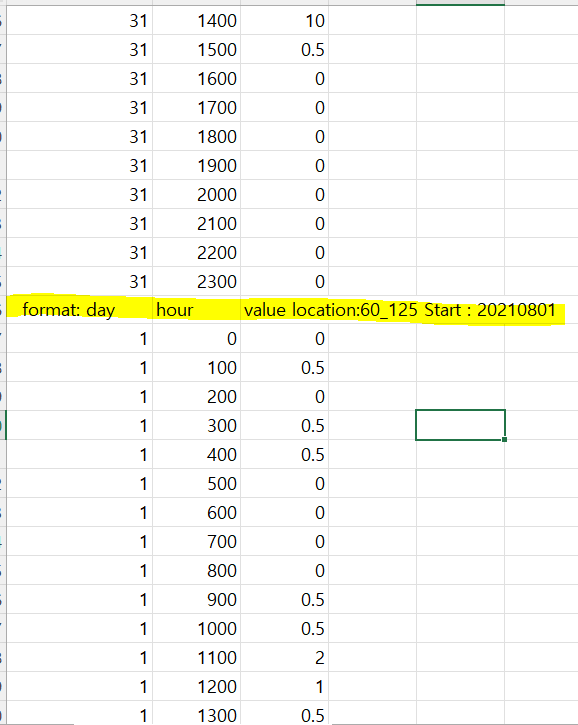

In [44]:
#정상적인 데이터라면 744개여야하는데
pd.read_csv('/content/weathers/가경동_강수_202108_202108.csv')

,format: day,hour,value location:68_106 Start : 20210801
0,1,0,0.000000
1,1,100,0.000000
2,1,200,0.000000
3,1,300,0.000000
4,1,400,0.000000
...,...,...,...
739,31,1900,8.400000
740,31,2000,7.900000
741,31,2100,20.799999
742,31,2200,2.200000


In [ ]:
# 그 두배인 1489개가 존재. 정상 프레임을 중복으로 가로방향으로 붙여놓은 형태이다.
pd.read_csv('/content/weathers/반포4동_강수_202108_202108.csv')

,format: day,hour,value location:60_125 Start : 20210801
0,1,0000,0.000000
1,1,0100,0.500000
2,1,0200,0.000000
3,1,0300,0.500000
4,1,0400,0.500000
...,...,...,...
1484,31,1900,0.000000
1485,31,2000,0.000000
1486,31,2100,0.000000
1487,31,2200,0.000000


In [18]:
error_list

[(60, 126, '한강로동', '/content/weathers/한강로동_기온_202008_202107.csv')]

In [16]:
location[location['3단계']=='한강로동']

,1단계,2단계,3단계,격자 X,격자 Y
44,서울특별시,용산구,한강로동,60,126


In [25]:
#데이터가 가로로 두번 중복되어 들어있는 형태
test = pd.read_csv('/content/weathers/한강로동_기온_202008_202107.csv')
test

,format: day,hour,value location:60_126 Start : 20200801
0,1,0.0,27.299999
1,1,100.0,28.100000
2,1,200.0,26.299999
3,1,300.0,24.299999
4,1,400.0,25.000000
...,...,...,...
17539,NaN,NaN,NaN
17540,NaN,NaN,NaN
17541,NaN,NaN,NaN
17542,NaN,NaN,NaN


In [28]:
#원래 길이는 이러함.
origin = pd.read_csv('/content/weathers/가경동_기온_202008_202107.csv')
origin.columns = ['날짜','시간대','기온']
origin

,날짜,시간대,기온
0,1,0.0,29.100000
1,1,100.0,30.000000
2,1,200.0,30.000000
3,1,300.0,29.799999
4,1,400.0,29.299999
...,...,...,...
8766,31,1900.0,26.600000
8767,31,2000.0,26.600000
8768,31,2100.0,27.200001
8769,31,2200.0,27.799999


In [26]:
test = test.loc[:8770]
test

,format: day,hour,value location:60_126 Start : 20200801
0,1,0.0,27.299999
1,1,100.0,28.100000
2,1,200.0,26.299999
3,1,300.0,24.299999
4,1,400.0,25.000000
...,...,...,...
8766,31,1900.0,27.799999
8767,31,2000.0,27.700001
8768,31,2100.0,27.900000
8769,31,2200.0,28.100000


In [27]:
#기존 파일은 삭제
!rm -r '/content/weathers/한강로동_기온_202008_202107.csv'

In [28]:
#새로 저장
test.to_csv('/content/weathers/한강로동_기온_202008_202107.csv',index=False, encoding="utf-8-sig")

In [33]:
#확인. 그러나 여전히 에러 리스트에 담김
pd.read_csv('/content/weathers/한강로동_기온_202008_202107.csv')

,format: day,hour,value location:60_126 Start : 20200801
0,1,0.0,27.299999
1,1,100.0,28.100000
2,1,200.0,26.299999
3,1,300.0,24.299999
4,1,400.0,25.000000
...,...,...,...
8766,31,1900.0,27.799999
8767,31,2000.0,27.700001
8768,31,2100.0,27.900000
8769,31,2200.0,28.100000


In [38]:
df= pd.read_csv('/content/weathers/한강로동_기온_202008_202107.csv')
fname = '/content/weathers/한강로동_기온_202008_202107.csv'
start_date = df.columns[-1].strip()[-8:-2]
xy=np.array(df.columns[2].split(':')[1].split()[0].split("_"), dtype=int)
df.columns = ['날짜','시간대','기온']
df = df.astype({'날짜': 'string'})
  
'''날짜 col 재정의'''
df['new'] = np.where(df['시간대'].isna(), df['날짜'] , np.nan) # Start들어있는 행에서 날짜 뽑아넣기 Start 없는 행은 np.nan으로 채우기
df['new'] = df['new'].apply(lambda x : x[-9:-3] if str(x).startswith(' S') else x)
df.loc[0, 'new'] = start_date
df['new'] = df['new'].ffill()
df['new']=df['new']+df['날짜']
df = df.drop(df[df['시간대'].isna()].index) #원래 start들어있던 행 지우기
df = df.drop(['날짜'], axis = 1) #기존 날짜 행 지우고
df.columns = ['시간대','기온','날짜'] #new열을 날짜 열로 새롭게 정의
  
level3 = fname.split("_")[0].split('/')[-1] 
if level3=='대정읍': #대정읍_마라도포함_강수_201908_202007
  level3='대정읍/마라도포함'
  

SiDo = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['1단계'].values[0]
SiGunGu = location[(location['격자 X']==xy[0]) & (location['격자 Y']==xy[1]) & (location['3단계']==level3)]['2단계'].values[0]
    
'''컬럼 추가 후 값 넣기'''
df['읍면동'] = level3 
df['광역시도'] = SiDo
df['시군구'] = SiGunGu

'''시간대 배달데이터 형태로 바꾸기'''
df = df.astype({'시간대': 'int'})
df['시간대'] = [hour//100 if hour != 0 else hour for hour in df['시간대']]                  
    
'''datetime형식으로 변환'''
df['날짜'] = pd.to_datetime(df['날짜'], format='%Y%m%d')
    
'''재정렬 및 합칠 데이터프레임 리스트 만들기'''
df = df[['광역시도','시군구','읍면동', '날짜', '시간대',  '기온']]

df

,광역시도,시군구,읍면동,날짜,시간대,기온
0,서울특별시,용산구,한강로동,2020-08-01,0,27.299999
1,서울특별시,용산구,한강로동,2020-08-01,1,28.100000
2,서울특별시,용산구,한강로동,2020-08-01,2,26.299999
3,서울특별시,용산구,한강로동,2020-08-01,3,24.299999
4,서울특별시,용산구,한강로동,2020-08-01,4,25.000000
...,...,...,...,...,...,...
8766,서울특별시,용산구,한강로동,2021-07-31,19,27.799999
8767,서울특별시,용산구,한강로동,2021-07-31,20,27.700001
8768,서울특별시,용산구,한강로동,2021-07-31,21,27.900000
8769,서울특별시,용산구,한강로동,2021-07-31,22,28.100000


In [39]:
len(concat_list)

5265

In [40]:
len(temp2)

5266

In [41]:
concat_list.append(df)
len(concat_list)

5266